<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Polyp_Segmentation_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="polyp-segmentationt"></a>
# Polyp Segmentation

<a name="objectives"></a>
## Objective
In the previous notebook, we have explored the polyp images and masks, as well as preprocessing and split data into train, validation, and test set.


## Table of contents
  * [Polyp Segmentation](#polyp-segmentation)
    * [Objective](#objectives)
    * [Table of Contents](#table-of-contents)
    * [Library import](#library-import)
    * [Load data](#load-data)
    * [Functions definition](#functions-definition)
    * [Classes and methods definition](#classes-methods-definition)
    * [Variational Autoencoder Model](#vae-model)
      * [Model configuration](#model-configuration)
      * [Model training](#model-training)
      * [Model evaluation](#model-evaluation)
        * [Confusion matrix](#confusion-matrix)
        * [Classification report](#classification-report)
        * [IoU and Dice Coefficient](#iou-and-dice-coefficient)
      * [Mask prediction](#mask-prediction)
      * [Reconstructed image](#reconstructed-image)
      * [Conclusion](#conclusion)

<a name="library-import"></a>
## Library import

In [ ]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, ReLU, Dropout, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from keras.regularizers import l2

# File and Data Handling
import zipfile
import gdown
import os
import numpy as np

# Random for generating random numbers
import random

# Plotting and Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Image processing
import cv2

<a name="classes-methods-definition"></a>
## Classes and methods definition

In [ ]:
class VAE(Model):
    """
      Variational Autoencoder (VAE) model for image segmentation.

      The VAE model consists of an encoder and a decoder. The encoder is responsible for mapping the input images to a lower-dimensional latent space, while the decoder is responsible for reconstructing the input images from the latent space. The model is trained using a combination of reconstruction loss and segmentation loss, with a KL divergence term to encourage the latent space to follow a Gaussian distribution.

      Args:
          encoder (tf.keras.Model): The encoder model.
          decoder (tf.keras.Model): The decoder model.
          **kwargs: Additional keyword arguments to be passed to the parent class.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        """
          Forward pass through the VAE model.

          Args:
              inputs (tf.Tensor): The input images.

          Returns:
              tf.Tensor: The reconstructed images.
              tf.Tensor: The segmentation masks.
        """
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed, segmentation = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed, segmentation

    def train_step(self, data):
        """
          A single training step for the VAE model.

          Args:
              data (tuple of tf.Tensor): The input images and segmentation masks.

          Returns:
              dict: A dictionary of scalar metrics to be logged.
        """
        x, y = data
        with tf.GradientTape() as tape:
            reconstructed, segmentation = self(x, training=True)
            reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructed))
            segmentation_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, segmentation))
            total_loss = reconstruction_loss + segmentation_loss + sum(self.losses)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "segmentation_loss": segmentation_loss, "kl_loss": sum(self.losses)}

    def test_step(self, data):
        """
        A single test/evaluation step for the VAE model.

        Args:
            data (tuple of tf.Tensor): The input images and segmentation masks.

        Returns:
            dict: A dictionary of scalar metrics to be logged.
        """
        x, y = data
        reconstructed, segmentation = self(x, training=False)
        reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructed))
        segmentation_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, segmentation))
        total_loss = reconstruction_loss + segmentation_loss + sum(self.losses)
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "segmentation_loss": segmentation_loss, "kl_loss": sum(self.losses)}

    def get_config(self):
        """
          Returns the config dictionary for the VAE model.

          Returns:
              dict: The config dictionary.
        """
        config = super(VAE, self).get_config()
        config.update({
            "encoder_config": self.encoder.get_config(),
            "decoder_config": self.decoder.get_config(),
            "encoder_class_name": self.encoder.__class__.__name__,
            "decoder_class_name": self.decoder.__class__.__name__,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a new instance of the VAE class from a configuration dictionary.

        Args:
            config (dict): A dictionary containing the configuration of the VAE class.

        Returns:
            A new instance of the VAE class.
        """
        encoder_config = config.pop("encoder_config")
        decoder_config = config.pop("decoder_config")
        encoder_class_name = config.pop("encoder_class_name")
        decoder_class_name = config.pop("decoder_class_name")

        encoder = tf.keras.models.model_from_config(encoder_config, custom_objects={'Sampling': Sampling})
        decoder = tf.keras.models.model_from_config(decoder_config)

        return cls(encoder, decoder, **config)

class Sampling(Layer):
    """ Capa para muestrear un punto z del espacio latente dado las medias y logaritmos de las varianzas. """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class CustomMetricsCallback(tf.keras.callbacks.Callback):
    """
      Callback for computing custom metrics (IoU and Dice Coefficient).

      Attributes:
          validation_data (tf.data.Dataset): Validation dataset.
          iou_scores (list): List to store IoU scores.
          dice_scores (list): List to store Dice Coefficients.

      Methods:
          __init__(validation_data): Initializes the callback.
          on_epoch_end(epoch, logs): Callback at the end of each epoch.

    """
    def __init__(self, validation_data):
        """
          Initializes the callback.

          Args:
              validation_data (tf.data.Dataset): Validation dataset.

          Returns:
              None

        """
        super().__init__()
        self.validation_data = validation_data
        self.iou_scores = []
        self.dice_scores = []

    def on_epoch_end(self, epoch, logs=None):
        """
          Callback at the end of each epoch.

          Args:
              epoch (int): Current epoch.
              logs (dict): Dictionary containing training and validation metrics.

          Returns:
              None

        """
        val_images, val_masks = next(iter(self.validation_data))
        predictions = self.model.predict(val_images)
        segmentations = predictions['segmentation']
        iou_score = calculate_iou(val_masks.numpy(), (segmentations > 0.5).astype(int))
        dice_numerator, dice_denominator = dice_coefficient(val_masks.numpy(), (segmentations > 0.5).astype(int))
        dice_score = dice_numerator/dice_denominator
        self.iou_scores.append(iou_score)
        self.dice_scores.append(dice_score)
        print(f"Epoch {epoch + 1}: IoU Score: {iou_score:.4f}, Dice Coefficient: {dice_score:.4f}")

class ImageMaskDataGenerator(Sequence):
    """
      A data generator for images and their corresponding masks for training deep learning models.

      This generator inherits from Keras' Sequence class and is designed to load image and mask pairs
      from directories, process them, and yield them in batches for model training. It ensures efficient
      data loading and optional shuffling at the end of each epoch.

      Attributes:
          image_dir (str): Directory containing the input images.
          mask_dir (str): Directory containing the corresponding masks.
          batch_size (int): Number of image-mask pairs per batch.
          image_size (tuple): Target size to which images and masks are resized.
          shuffle (bool): Whether to shuffle the data after each epoch.
          image_filenames (list): List of filenames in the image directory.
    """
    def __init__(self, image_dir, mask_dir, batch_size, image_size=(256, 256), shuffle=True):
        """
          Initializes the data generator with directories, batch size, image size, and shuffle option.

          Args:
              image_dir (str): Directory containing the input images.
              mask_dir (str): Directory containing the corresponding masks.
              batch_size (int): Number of image-mask pairs per batch.
              image_size (tuple, optional): Target size to which images and masks are resized. Defaults to (256, 256).
              shuffle (bool, optional): Whether to shuffle the data after each epoch. Defaults to True.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)
        self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.

        Returns:
            int: The number of batches per epoch.
        """
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        """
          Generates one batch of data.

          Args:
              index (int): Index of the batch to generate.

          Returns:
              tuple: A tuple containing a batch of images and their corresponding masks.
        """
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        for filename in batch_filenames:
            img_path = os.path.join(self.image_dir, filename)
            mask_path = os.path.join(self.mask_dir, filename)
            img = load_img(img_path, target_size=self.image_size)
            mask = load_img(mask_path, target_size=self.image_size, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            mask_array = img_to_array(mask) / 255.0
            images.append(img_array)
            masks.append(mask_array)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
          Shuffles the order of the data after each epoch if shuffle is set to True.
        """
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

<a name="functions-definition"></a>
## Functions definition

In [ ]:
def load_dataset(root_dir, subset, batch_size=16, image_size=(256, 256), seed = 123):
    """
        Load images and masks from the specified directory and create a TensorFlow dataset.

        Args:
            root_dir (str): Root directory containing image and mask subdirectories.
            subset (str): Subset of the dataset ('train', 'val', or 'test').
            batch_size (int, optional): Batch size. Defaults to 16.
            image_size (tuple, optional): Size to resize the images. Defaults to (256, 256).
            seed (int, optional): Random seed for shuffling. Defaults to 123.

        Returns:
            tf.data.Dataset: TensorFlow dataset containing images and masks.

    """
    image_path = f"{root_dir}/{subset}/images/{subset}"
    mask_path = f"{root_dir}/{subset}/masks/{subset}"

    image_files = tf.data.Dataset.list_files(f"{image_path}/*.jpg", seed = seed)
    mask_files = tf.data.Dataset.list_files(f"{mask_path}/*.jpg", seed = seed)

    def parse_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = img / 255.0
        return img

    def parse_mask(file_path):
        mask = tf.io.read_file(file_path)
        mask = tf.image.decode_jpeg(mask, channels=1)
        mask = tf.image.resize(mask, image_size)
        mask = mask / 255.0
        return mask

    images = image_files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    masks = mask_files.map(parse_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((images, masks))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

def calculate_iou(y_true, y_pred):
    """
      Calculate the Intersection over Union (IoU) score between ground truth and predicted masks.

      Args:
          y_true (numpy.ndarray): Ground truth masks.
          y_pred (numpy.ndarray): Predicted masks.

      Returns:
          float: Intersection over Union (IoU) score.

    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def dice_coefficient(y_true, y_pred):
    """
      Calculate the Dice coefficient between ground truth and predicted masks.

      Args:
          y_true (numpy.ndarray): Ground truth masks.
          y_pred (numpy.ndarray): Predicted masks.

      Returns:
          tuple: Dice numerator and denominator.

    """
    intersection = np.sum(y_true * y_pred)
    dice_numerator = 2.0 * intersection
    dice_denominator = np.sum(y_true) + np.sum(y_pred)
    return dice_numerator, dice_denominator

def build_encoder(latent_dim):
    """
      Build the encoder part of the Variational Autoencoder (VAE).

      Args:
          latent_dim (int): Dimensionality of the latent space.

      Returns:
          tf.keras.Model: Encoder model.

    """
    inputs = Input(shape=(256, 256, 3))

    # First convolutional layer
    x = Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu', strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional layer
    x = Conv2D(64, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu', strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # # Third convolutional layer
    x = Conv2D(128, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # # Fourth convolutional layer
    x = Conv2D(256, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # # Fifth convolutional layer
    x = Conv2D(512, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    return encoder

def build_decoder(latent_dim):
    """
      Build the decoder part of the Variational Autoencoder (VAE).

      Args:
          latent_dim (int): Dimensionality of the latent space.

      Returns:
          tf.keras.Model: Decoder model.

    """
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(8*8*512, activation='relu')(latent_inputs)
    x = Reshape((8,8, 512))(x)

    x = Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    reconstructed = Conv2DTranspose(3, 3, strides=2, activation='sigmoid', padding='same')(x)
    segmentation = Conv2DTranspose(1, 3, strides=2, activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, [reconstructed, segmentation], name='decoder')
    decoder.summary()
    return decoder

def plot_images(dataset,split_name):
  """
  Plot a grid of images and masks from a dataset.

  Args:
      dataset (tf.data.Dataset): Dataset containing images and masks.
      split_name (str): Name of the dataset split ('train', 'val', or 'test').

  Returns:
      None

  """

  # Initialize an empty list to store the samples
  samples = []

  # Iterate over the train_dataset and count the samples
  for batch in dataset:
      samples.append(batch[0].shape[0])  # Assuming the images are in the first element of each batch

  # Get the total number of samples
  num_samples = sum(samples)

  # Print the number of samples, batch size, and number of batches
  print(f"{split_name} images\n" + '--' * 15)
  print(f"Number of samples: {num_samples}\n")

  # Set the number of rows and columns for the grid
  num_rows = 2
  num_cols = 5
  total_images = num_rows * num_cols # total of 15 images to display

  # Initialize variables to store min and max pixel values
  min_image_pixel_value = float('inf')
  max_image_pixel_value = float('-inf')
  min_mask_pixel_value = float('inf')
  max_mask_pixel_value = float('-inf')

  # Plot the images and masks in a grid
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))

  # Get the first batch from the dataset
  for images, masks in dataset.take(1):
      batch_images = images[:total_images]
      batch_masks = masks[:total_images]

  # Iterate over the images in the test batch and plot them in the grid
  i=0
  for j in range(num_cols):
      index = i * num_cols + j

      # Plot the image
      axes[i, j].imshow(batch_images[index], cmap='gray')
      axes[i, j].axis('off')

      # Plot the mask
      axes[i+1, j].imshow(batch_masks[index], cmap='gray')
      axes[i+1, j].axis('off')

      # Update min and max pixel values
      min_image_pixel_value = min(min_image_pixel_value, tf.reduce_min(batch_images[index]).numpy())
      max_image_pixel_value = max(max_image_pixel_value, tf.reduce_max(batch_images[index]).numpy())
      min_mask_pixel_value = min(min_mask_pixel_value, tf.reduce_min(batch_masks[index]).numpy())
      max_mask_pixel_value = max(max_mask_pixel_value, tf.reduce_max(batch_masks[index]).numpy())

  # Adjust the spacing between subplots
  plt.subplots_adjust(top = 0.89, wspace=0.1, hspace=0.2)

  fig.suptitle(f"{split_name} data", size=12, fontweight='bold')
  plt.figtext(0.5, 0.91, "Images", va="center", ha="center", size=12)
  plt.figtext(0.5, 0.48, "Masks", va="center", ha="center", size=12)

  # Show the plot
  plt.show()

  # Print the min and max pixel values
  print("\nMinimum image pixel value:", min_image_pixel_value)
  print("Maximum image pixel value:", max_image_pixel_value)
  print("Minimum mask pixel value:", min_mask_pixel_value)
  print("Maximum mask pixel value:", max_mask_pixel_value)


# Custom loss function for VAE
def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    """
      Compute the loss function for the Variational Autoencoder (VAE).

      Args:
          inputs: Input images.
          reconstructed: Reconstructed images.
          z_mean: Mean of the latent space.
          z_log_var: Log variance of the latent space.

      Returns:
          Tensor: VAE loss.

    """
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, reconstructed)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

def dice_loss(y_true, y_pred, smooth=1):
    """
      Compute the Dice loss between ground truth and predicted masks.

      Args:
          y_true: Ground truth masks.
          y_pred: Predicted masks.
          smooth (float, optional): Smoothing factor. Defaults to 1.

      Returns:
          Tensor: Dice loss.

    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def combined_loss(y_true, y_pred):
    """
    Computes a combined loss for multi-task learning, incorporating both reconstruction
    and segmentation losses.

    Args:
        y_true (tuple): Ground truth values containing:
            - y_true_reconstructed: True reconstructed images.
            - y_true_segmentation: True segmentation masks.
        y_pred (tuple): Predicted values containing:
            - y_pred_reconstructed: Predicted reconstructed images.
            - y_pred_segmentation: Predicted segmentation masks.

    Returns:
        tf.Tensor: Combined loss value.
    """

      # Define the reconstruction loss function
    reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()

    # Define the segmentation loss function
    segmentation_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Split the ground-truth and predicted outputs into two parts
    y_true_reconstructed, y_true_segmentation = y_true
    y_pred_reconstructed, y_pred_segmentation = y_pred

    # Compute the reconstruction loss
    reconstruction_loss = reconstruction_loss_fn(y_true_reconstructed, y_pred_reconstructed)

    # Compute the segmentation loss
    segmentation_loss = segmentation_loss_fn(y_true_segmentation, y_pred_segmentation)

    # Combine the two losses with a weighting factor
    combined_loss = reconstruction_loss + 1.0 * segmentation_loss

    return combined_loss

def post_process(mask):
    """
      Post-processes a segmentation mask by applying a threshold and morphological closing operation.

      Args:
          mask (np.array): Segmentation mask to be processed.

      Returns:
          np.array: Post-processed segmentation mask.
    """
    mask = (mask > 0.5).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closing

<a name="load-data"></a>
## Load data

<a name="extraction-data"></a>
### Extraction of data

In [ ]:
# URL of the file to download
url = 'https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM'

root_dir = '/tmp'

# Path to save the downloaded file locally
output_path = f"{root_dir}/prepared_data.zip"

# Download the file
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM
From (redirected): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM&confirm=t&uuid=97bf3115-ab04-4cd5-af92-15e38aa9f462
To: /tmp/prepared_data.zip
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s]


'/tmp/prepared_data.zip'

In [ ]:
# Extract data from zip
local_zip = output_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f"{root_dir}/prepared_data")
zip_ref.close()

In order to set up the generator properly, our image data is organized the same as the following structure. Note that it's important to make sure the images and masks within the set are stored in their respected subfolders with the same name. For example, both test images and test masks are stored in their respected subfolders with the same name "test".
```
prepared_data
├── test
│   ├── images
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   
├── train
│   ├── images
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   
├── valid
│   ├── images
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...


```

<a name="generate-data-batches"></a>
### Generate data batches

Prior to loading the dataset, the image data are resized to specific dimensions and rescaled to an interval from 0 to 1. This normalization ensures that the data fall within a similar interval and maintain a consistent scale, potentially improving model performance and convergence.

In addition, data augmentation techniques are employed to improve the diversity and variability of the training data. These techniques consist of applying random transformations, such as random flips, rotations and zooms, to the images. In this way, variations of the original images are created that ultimately improve the generalization and robustness of the deep learning model by exposing it to a wider range of image variations.

In [ ]:
# Set parameters for `generate_data_batches` function
data_dir = '/tmp/prepared_data'
batch_size = 32
seed = 123
image_size = (256, 256)


# Load the datasets
train_dataset = load_dataset(data_dir, 'train', batch_size=batch_size, image_size=image_size, seed = seed)
valid_dataset = load_dataset(data_dir, 'valid', batch_size=batch_size, image_size=image_size, seed = seed)
test_dataset = load_dataset(data_dir, 'test', batch_size=batch_size, image_size=image_size, seed = seed)

<a name="inspect-genereated-batches"></a>
### Inspect Genereated Batches

Once we set up the tensorflow datasets for the training, validation, and testing sets, we can have a look at the content of the data batches.

<a name="train-batches"></a>
#### Train set

Train images
------------------------------
Number of samples: 916



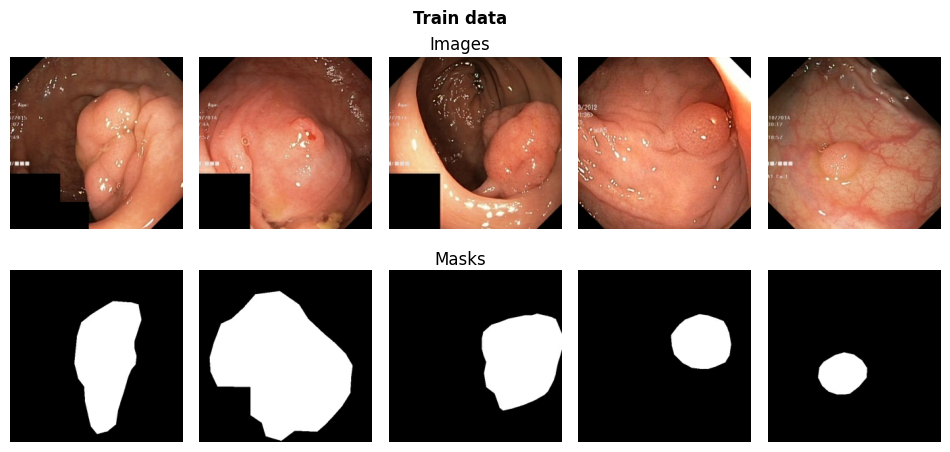


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = train_dataset
split_name = "Train"
plot_images(dataset,split_name)

We can see that in the EDA notebook, the minimum and maximum pixel value of our image is (0, 255). After rescaling, the the minimum and maximum pixel value of our image is between 0 and 1.


<a name="validation-batches"></a>
#### Validation set

For validation set, the number of images is smaller as compared to train set as we have lesser samples in the validation set than in the train set.

Validation images
------------------------------
Number of samples: 185



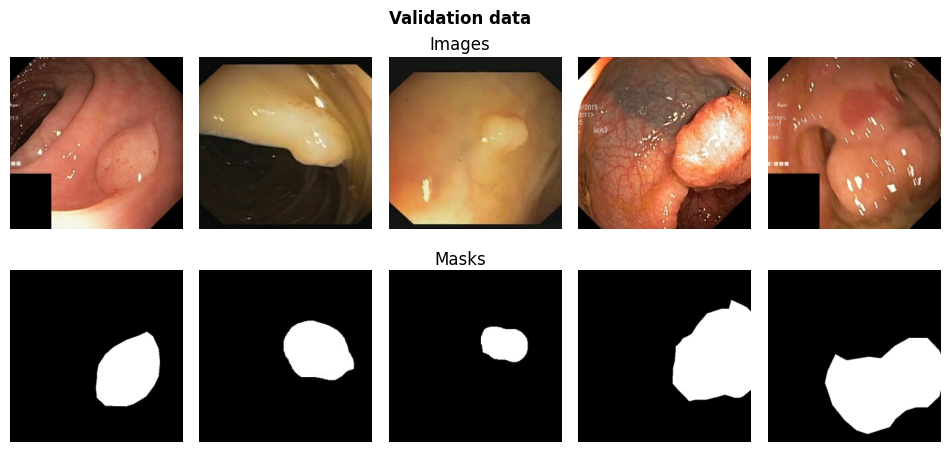


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = valid_dataset
split_name = "Validation"
plot_images(dataset,split_name)

Same as the train set, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="test-batch"></a>
#### Test batch

Test images
------------------------------
Number of samples: 189



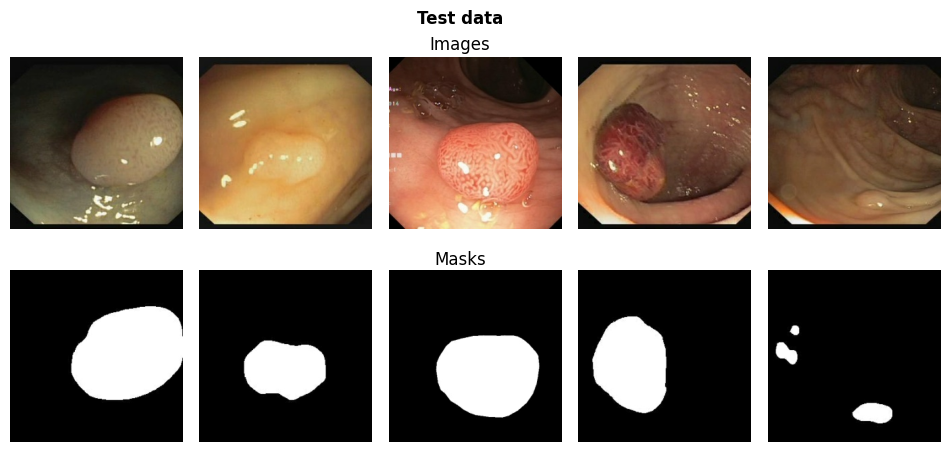


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = test_dataset
split_name = "Test"
plot_images(dataset,split_name)

Same as the train set, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="vae-model"></a>
## Variational Autoenconder Model

A Variational Autoencoder (VAE) is a type of neural network model used for unsupervised learning of complex data representations. It learns to encode input data into a lower-dimensional latent space, where it captures the underlying structure of the data. Key components include an encoder, which maps input data to a probability distribution in the latent space, and a decoder, which reconstructs the original data from samples drawn from this distribution. VAEs are probabilistic models, enabling them to generate new data samples by sampling from the learned latent space distribution. They are valuable for tasks like image generation, text modeling, and data representation learning.

<a name="model-architecture"></a>
### Model architecture
The VAE architecture can be visualized as Encoder - Decoder. Here's a breakdown of its structure:

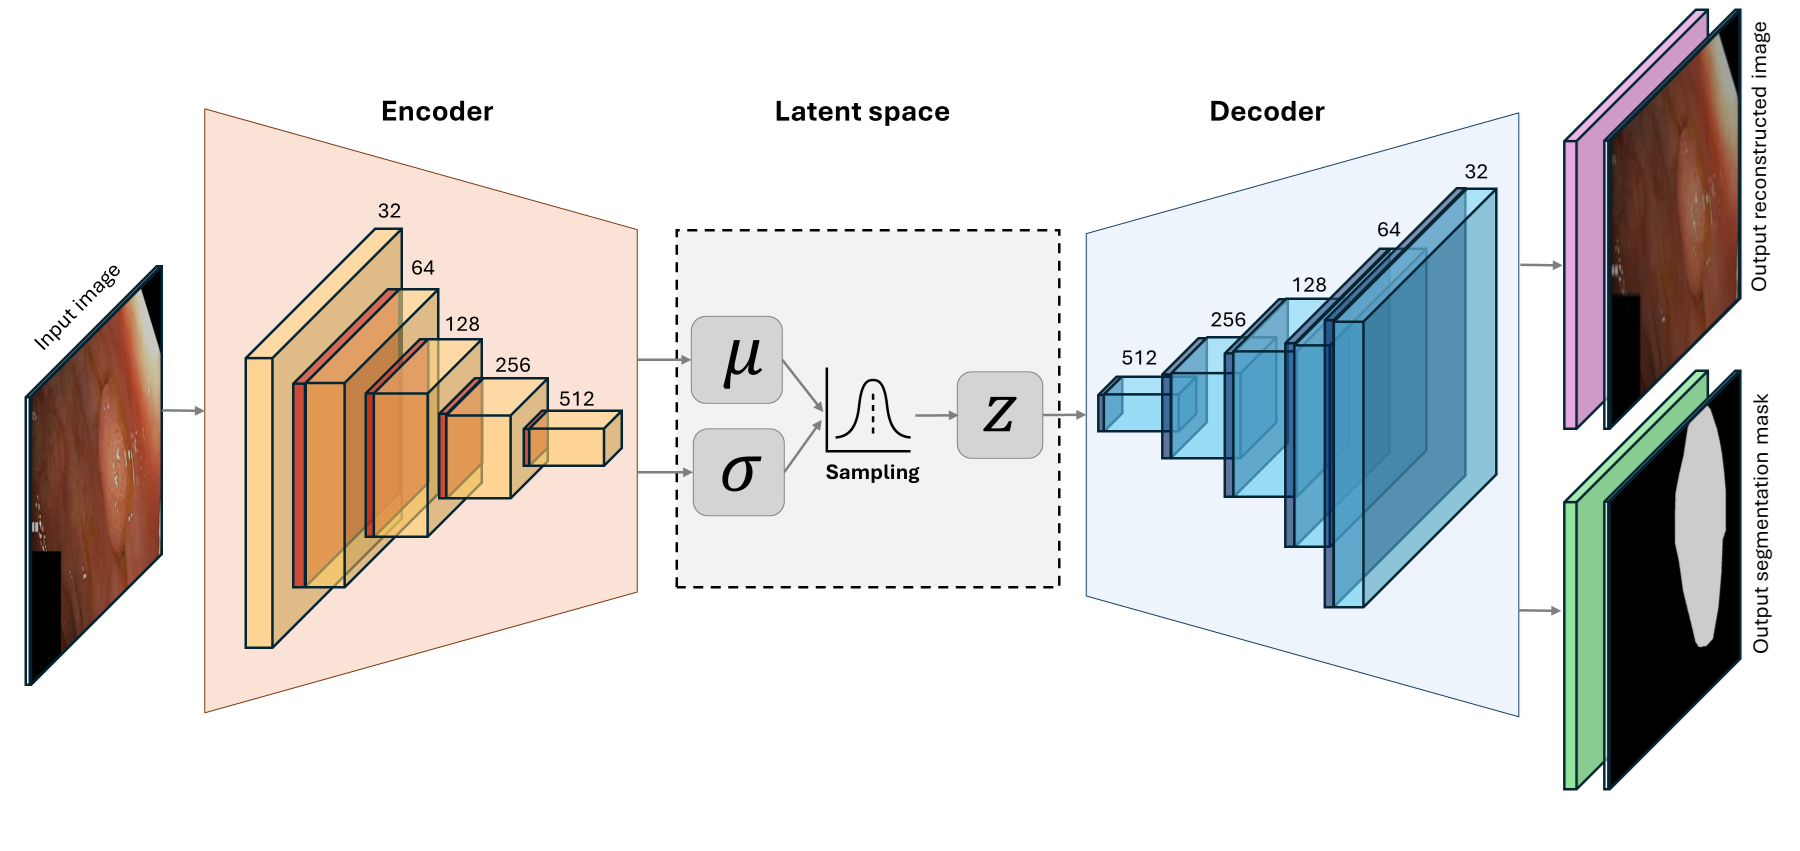

**Encoder**: Captures essential features and compresses input into latent variables (μ and σ).

**Latent Space**: Probabilistic space representing the compressed form of input, sampled via reparameterization.

**Decoder**: Reconstructs the input from the latent variable, upsampling through transposed convolutions.

**Output Layer**: Final layer reconstructs the input image, usually using a sigmoid or tanh activation.

**Loss Function**: Combination of reconstruction loss and KL divergence to ensure accurate reconstruction and smooth latent space.

In [ ]:
# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

<a name="model-configuration"></a>
### Model configuration

In this section, the VAE model will be configured for training. The functions build_encoder and build_decoder are executed with latent_dim as argument to build the encoder and decoder parts of the VAE, respectively. The encoder compresses the input data into the 200-dimensional latent space, while the decoder reconstructs the input data from the latent representation. The model will be trained for 100 epochs.

In [ ]:
latent_dim = 110
epochs = 100

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['batch_normalization[0]

A Variational Autoencoder (VAE) model is created and compiled by first instantiating the VAE class with the previously constructed encoder and decoder. It then compiles the model using the Adam optimizer with a learning rate of 1e-4, specifying a combined loss function for multi-task learning, incorporating both reconstruction
and segmentation losses. This setup prepares the VAE model for training, defining how its performance will be optimized and evaluated.

In [ ]:
# Instance VAE class
model = VAE(encoder, decoder)

# Compile the model with the new loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss)

<a name="model-training"></a>
### Model training

Once the model is successfully compiled, it is ready for training. The following are key points for setting up the training process correctly:

1. **Custom Callback for Metrics**: A custom callback is created to capture additional metrics during training, using *valid_dataset* for validation data.

2. **Model Checkpoint**: The `ModelCheckpoint` callback saves the model's weights at *./model/vae_V1.h5* whenever the validation loss improves, ensuring the best model is saved.

3. **Early Stopping**: The `EarlyStopping` callback monitors the validation loss and stops training if it doesn't improve for **20** consecutive epochs, restoring the best weights to prevent overfitting.

4. **Learning Rate Reduction**: The `ReduceLROnPlateau` callback reduces the learning rate by a factor of **0.1** if the validation loss plateaus for **8** epochs, with a minimum learning rate of **1e-5**, to aid model convergence.

5. **Class Weight Adjustment**: Class weights are set to handle class imbalance, calculated based on the ratio of the total number of samples to the number of samples in each class.

6. **Training**: The fit method trains the model on train_dataset for the specified number of epochs, using valid_dataset for validation. The class_weight parameter adjusts for class imbalance, and the training process is monitored by the specified callbacks (early_stopping and lr_schedule).



In [ ]:
# Custom callback for capturing metrics
custom_metrics_callback = CustomMetricsCallback(validation_data=valid_dataset)

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
checkpoint_path = './model/vae_v1'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True,save_weights_only=False,save_format='tf',verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)

history =model.fit(x=train_dataset,
                   y=None,
                   steps_per_epoch=len(train_dataset),
                   epochs=epochs,
                   validation_data=valid_dataset,
                   validation_steps=len(valid_dataset),
                   callbacks=[model_checkpoint, early_stopping, reduce_lr])


# Save the model architecture to a JSON file if needed
model_json = model.to_json()
with open("vae10_model.json", "w") as json_file:
    json_file.write(model_json)


# Display the model's architecture
model.summary()

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 3.0960 - reconstruction_loss: 0.1070 - segmentation_loss: 0.7295 - kl_loss: 2.2595
Epoch 1: val_loss improved from inf to 0.80392, saving model to ./model/vae_v1
29/29 [==============================] - 33s 464ms/step - loss: 3.0603 - reconstruction_loss: 0.1068 - segmentation_loss: 0.7288 - kl_loss: 2.2246 - val_loss: 0.8039 - val_reconstruction_loss: 0.0908 - val_segmentation_loss: 0.6910 - val_kl_loss: 0.0222 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 1.8127 - reconstruction_loss: 0.1012 - segmentation_loss: 0.6982 - kl_loss: 1.0133
Epoch 2: val_loss did not improve from 0.80392
29/29 [==============================] - 5s 127ms/step - loss: 1.8088 - reconstruction_loss: 0.1012 - segmentation_loss: 0.6980 - kl_loss: 1.0096 - val_loss: 0.8218 - val_reconstruction_loss: 0.0894 - val_segmentation_loss: 0.6813 - val_kl_loss: 0.0511 - lr: 1.0000e-04
Epoch 3/100
29/29 [==========

When the training is completed, the `fit` method will return a **History** object, which is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

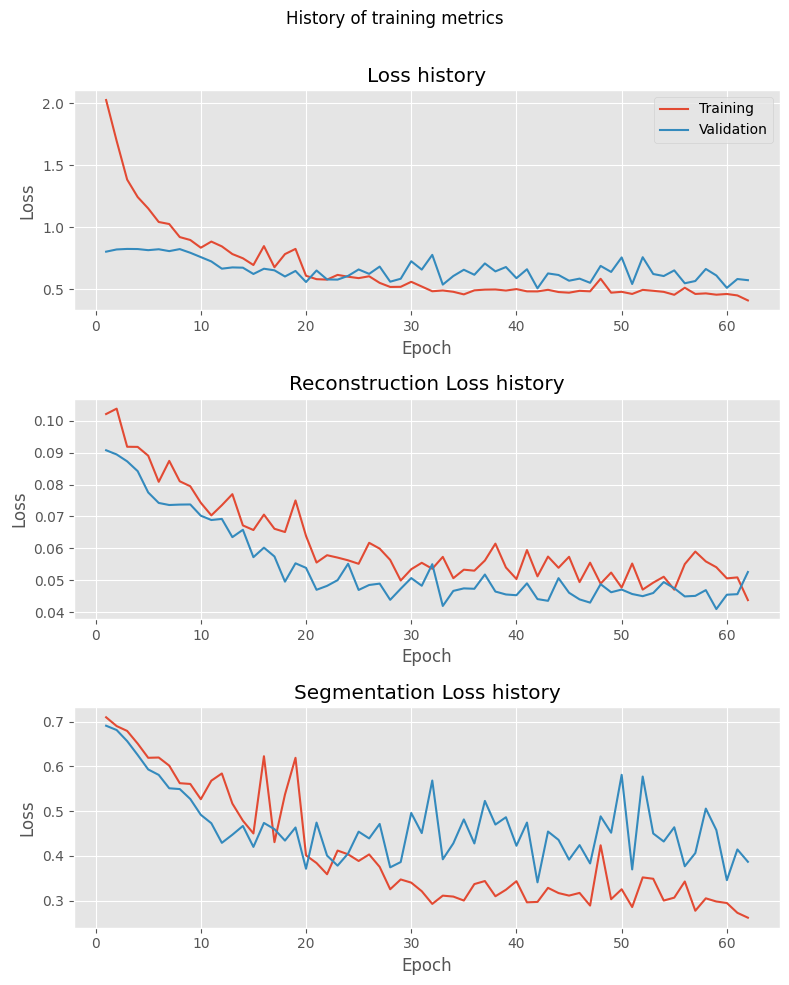

In [ ]:
# Get the history of accuracy and loss from the `history` object
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstructed_loss = history.history['reconstruction_loss']
val_reconstructed_loss = history.history['val_reconstruction_loss']
segmentation_loss = history.history['segmentation_loss']
val_segmentation_loss = history.history['val_segmentation_loss']

# Create subplots
fig, axes = plt.subplots(3,1, figsize=(8, 10))

axes[0].plot(range(1, len(loss) + 1), loss, label='Training')
axes[0].plot(range(1, len(val_loss) + 1), val_loss, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss history')
axes[0].legend()

axes[1].plot(range(1, len(reconstructed_loss) + 1), reconstructed_loss, label='Training')
axes[1].plot(range(1, len(val_reconstructed_loss) + 1), val_reconstructed_loss, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss history')

axes[2].plot(range(1, len(segmentation_loss) + 1), segmentation_loss, label='Training')
axes[2].plot(range(1, len(val_segmentation_loss) + 1), val_segmentation_loss, label='Validation')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Segmentation Loss history')

# Adjust the layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top = 0.9, hspace = 0.4)
fig.suptitle("History of training metrics")
plt.show()

The following conclusions can be drawn from the training history:
- Overall loss: the total loss calculated on the training data for each epoch encompasses all the individual loss components defined in the model. In the figure, both training and validation lines decrease over the epochs, indicating that the model is learning from the training data and is able to generalize this learning to the validation data.
- Reconstruction loss: this plot shows the reconstruction loss, which measures the ability of the VAE to reconstruct the input data after encoding and decoding. Both lines are steadily decreasing, which means that VAE reconstructions are becoming more and more accurate.
- Segmentation loss: Segmentation loss refers to a task-specific loss. Decreasing segmentation loss suggests better performance on the segmentation task.

Overall, the model shows good performance, with robust validation metrics and no immediate signs of overfitting. 'Re-constructed_loss' and 'Segmentation_loss' are the individual components of the total loss and are used to understand the behavior of the model and diagnose potential problems.

For all three loss types a lag between the training and validation lines is observed, which is not too large and relatively stable. Therefore, in the next section we will consider other metrics better suited to assess segmentation performance.

<a name="model-evaluation"></a>
### Model evaluation

Other than accuracy, the other metrics that are often used in evaluating segmentation performance are:
- Precision
- Recall
- IoU (Intersection over Union)
- Dice Coefficient


After training the model, a post-processing is performed on the segmentation mask predictions by applying a threshold and a morphological closure operation.

<a name="confusion-matrix"></a>
#### Confusion matrix

All presented metrics above are based on the computation of a **confusion matrix**, which represent the number of pixels that were correctly or incorrectly classified as either the object of interest or the background.

1/1 [==============================] - 0s 350ms/step
Confusion Matrix:
 [[1712366  116512]
 [ 151438  116836]]


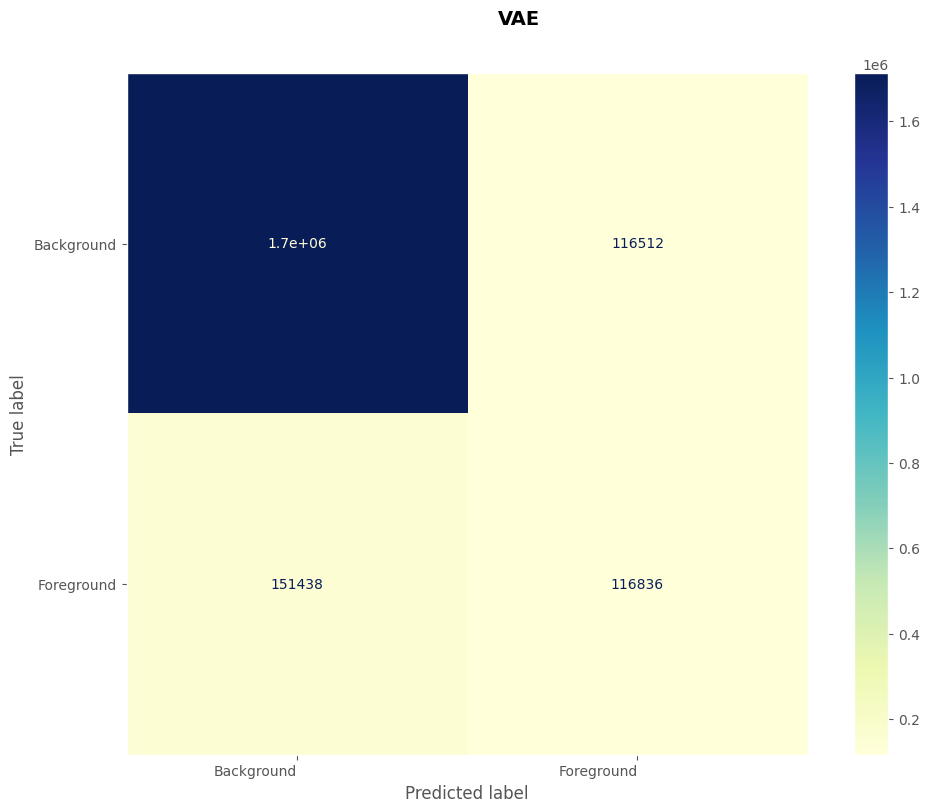

In [ ]:
# Evaluate on test data
test_images, test_masks = next(iter(test_dataset))
predictions = model.predict(test_images)
reconstructed_images, segmentations = predictions

# Convert to binary masks
test_masks_binary = tf.cast(test_masks > 0.5, dtype=tf.float32)
segmentations_binary = tf.cast(segmentations > 0.5, dtype=tf.float32)

# Flatten the binary masks
test_masks_flat = tf.reshape(test_masks_binary, [-1])
segmentations_flat = tf.reshape(segmentations_binary, [-1])

class_names = ["Background", "Foreground"]

# Apply post-processing to the segmentations
segmentations_processed = np.array([post_process(seg) for seg in segmentations])

# Flatten the processed segmentations
segmentations_processed_flat = segmentations_processed.flatten()

# Confusion Matrix
conf_matrix = confusion_matrix(test_masks_flat, segmentations_processed_flat)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
fig, axes = plt.subplots(figsize=(10,8))
plt.tight_layout()
plt.subplots_adjust(top=0.9)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.YlGnBu, ax=axes)
disp.ax_.grid(False)

plt.setp(disp.ax_.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
plt.setp(disp.ax_.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
disp.figure_.suptitle("VAE", fontsize=14, weight='bold')

plt.show()

From the confusion matrix, we can observe that:
- **True Positive (TP):** 116.836 pixels were correctly identified as the object of interest.
- **True Negative (TN):** 1'712.366 pixels were correctly identified as the background.
- **False Positive (FP):** 116.512 pixels were incorrectly identified as the object of interest.
- **False Negative (FN):** 151,438 pixels were incorrectly identified as the background.

<a name="classification-report"></a>
#### Classification report


It is posible to use the values from the confusion matrix (TP, TN, FP, and FN) to calculate evaluation metrics such as precision, recall, IoU, and dice coefficient, which provide a comprehensive assessment of the model's segmentation performance.

In [ ]:
# Classification Report
class_report = classification_report(test_masks_flat, segmentations_processed_flat, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

  Background       0.92      0.94      0.93   1828878
  Foreground       0.50      0.44      0.47    268274

    accuracy                           0.87   2097152
   macro avg       0.71      0.69      0.70   2097152
weighted avg       0.87      0.87      0.87   2097152



The classification report illustrates a notable contrast in the performance of the variational autoencoder between background and foreground classes. While achieving an overall accuracy of 87%, the model exhibits strong precision and recall for the background class (0.92 and 0.94, respectively), indicating robust identification of background instances. In contrast, the foreground class shows lower precision (0.50) and recall (0.44), resulting in a substantially lower F1-score (0.47), highlighting challenges in correctly identifying foreground instances. Consequently, the macro average F1-score is moderate at 0.70, reflecting the imbalanced performance between classes, with the weighted average F1-score (0.87) influenced by the larger number of background samples.

<a name="iou-and-dice-coefficient-(f1-score)"></a>
#### IoU and Dice coefficient (F1 score)

F-measure, also called F-score, is one of the most widespread scores for performance measuring in MIS (Medical Image Segmentation). Based on the F-measure, there are two popular utilized metrics in MIS:
- Intersection over Union (IoU)
- Dice coefficient

**Intersection over Union (IoU)**, also known as *Jaccard index*, is the area of the intersection over union of the predicted segmentation and the ground truth.
$$
IoU = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$
<br>

**Dice coefficient = F1-score**, is the harmonic mean of precision and recall. In another words, dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images
$$
Dice = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}
$$
<br>


<a name="iou-and-dice-coefficient"></a>
#### IoU and Dice Coefficient

In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Lists to store individual IoU and Dice values for standard deviation calculation
iou_values = []
dice_values = []

# Get the total number of samples in the test set
num_samples = len(list(test_dataset))

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
for batch_images, batch_masks in test_dataset:
    # Generate predictions for the batch
    batch_predictions = model.predict(batch_images, verbose=0)
    reconstructed_images, segmentations = batch_predictions

    # Apply post-processing to the segmentations
    segmentations_processed = np.array([post_process(seg) for seg in segmentations])

    # Threshold the predictions to obtain binary masks
    binary_predictions = (segmentations_processed > 0.5).astype(np.uint8)

    # Compute intersection and union for the batch
    batch_masks_squeezed = np.squeeze(batch_masks.numpy(), axis=-1)
    intersection = np.logical_and(batch_masks_squeezed, binary_predictions)
    union = np.logical_or(batch_masks_squeezed, binary_predictions)

    # Compute IoU for the batch
    batch_iou = np.sum(intersection) / np.sum(union)
    iou_values.append(batch_iou)

    # Compute Dice coefficient for the batch
    batch_masks_squeezed = np.squeeze(batch_masks.numpy(), axis=-1)
    dice_numerator, dice_denominator = dice_coefficient(batch_masks_squeezed, binary_predictions)
    batch_dice = dice_numerator / dice_denominator
    dice_values.append(batch_dice)

    # Update the totals
    total_intersection += np.sum(intersection)
    total_union += np.sum(union)
    total_dice_numerator += dice_numerator
    total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Compute the standard deviation for IoU and Dice coefficient
std_iou = np.std(iou_values)
std_dice = np.std(dice_values)

# Print the mean and standard deviation for IoU and Dice coefficient
print(f"Mean IoU: {mean_iou}\nStd IoU: {std_iou}")
print(f"Mean Dice Coefficient: {mean_dice}\nStd Dice Coefficient: {std_dice}")


Mean IoU: 0.24429727820702266
Std IoU: 0.05073218151489508
Mean Dice Coefficient: 0.3903611490654492
Std Dice Coefficient: 0.0670362314379423


The segmentation model's performance, as evaluated by the mean Intersection over Union (IoU) of 0.2443 with a standard deviation of 0.0507 and mean Dice coefficient of 0.3904 with standard deviation of 0.0670, indicates a moderate level of accuracy in delineating polyps in medical images. While these results suggest some success in capturing the spatial overlap and correspondence between predicted and ground truth masks, there remains room for improvement to achieve higher precision and consistency in segmentation.

<a name="reconstructed-image"></a>
### Reconstructed image (decoder output)

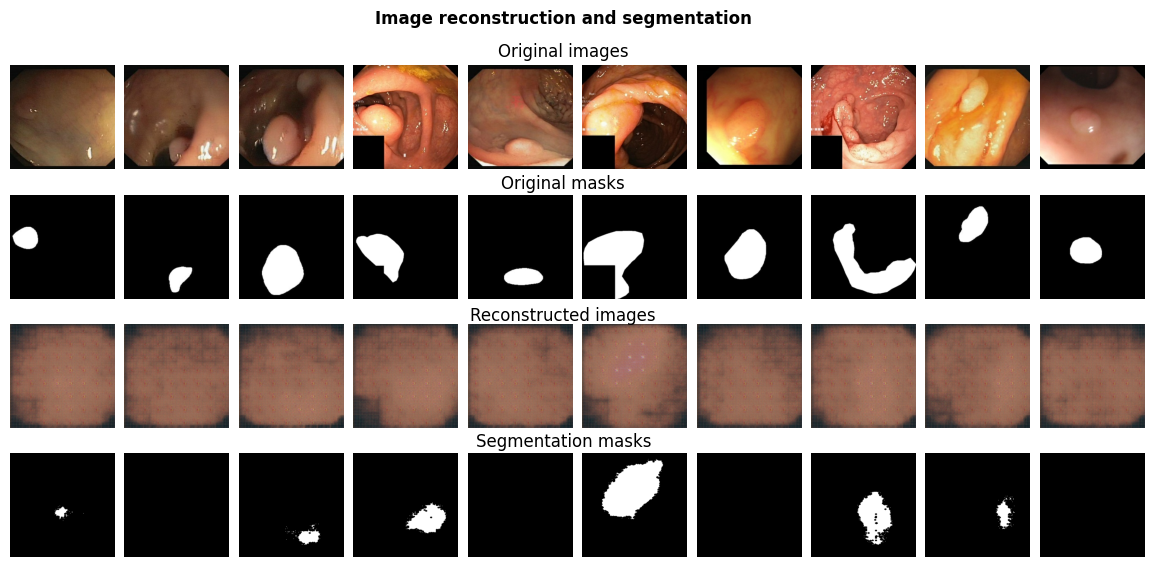

In [ ]:
original = test_images.numpy()
ground_t = test_masks.numpy()
reconstructed = reconstructed_images
segmentation = segmentations

# Apply post-processing to the segmentation masks
segmentation_processed = np.array([post_process(seg) for seg in segmentation])

fig, axes = plt.subplots(4,10, figsize = (12,6))
plt.tight_layout()

for i in range(10):
  # Original image
  axes[0,i].imshow(original[i])
  axes[0,i].axis('off')

  # Original mask
  axes[1,i].imshow(ground_t[i], cmap = "gray")
  axes[1,i].axis('off')

  # Reconstructed image
  axes[2,i].imshow(reconstructed[i])
  axes[2,i].axis('off')

  # Segmentation mask
  axes[3,i].imshow(segmentation_processed[i], cmap = "gray")
  axes[3,i].axis('off')

fig.suptitle("Image reconstruction and segmentation", fontweight = 'bold')
plt.subplots_adjust(top=0.89, wspace=0.1, hspace= 0.2)
plt.figtext(0.5, 0.91, "Original images", va="center", ha="center", size=12)
plt.figtext(0.5, 0.69, "Original masks", va="center", ha="center", size=12)
plt.figtext(0.5, 0.47, "Reconstructed images", va="center", ha="center", size=12)
plt.figtext(0.5, 0.26, "Segmentation masks", va="center", ha="center", size=12)
plt.plot();


<a name="mask-prediction"></a>
### Mask prediction

Four evaluation metrics—precision, recall, IoU, and dice coefficient—have been investigated to assess the model's effectiveness in segmenting polyps. To gain a comprehensive view of the model's performance, a qualitative assessment through visual inspections can now be conducted.

Random indices: [3, 17, 5, 26, 6]


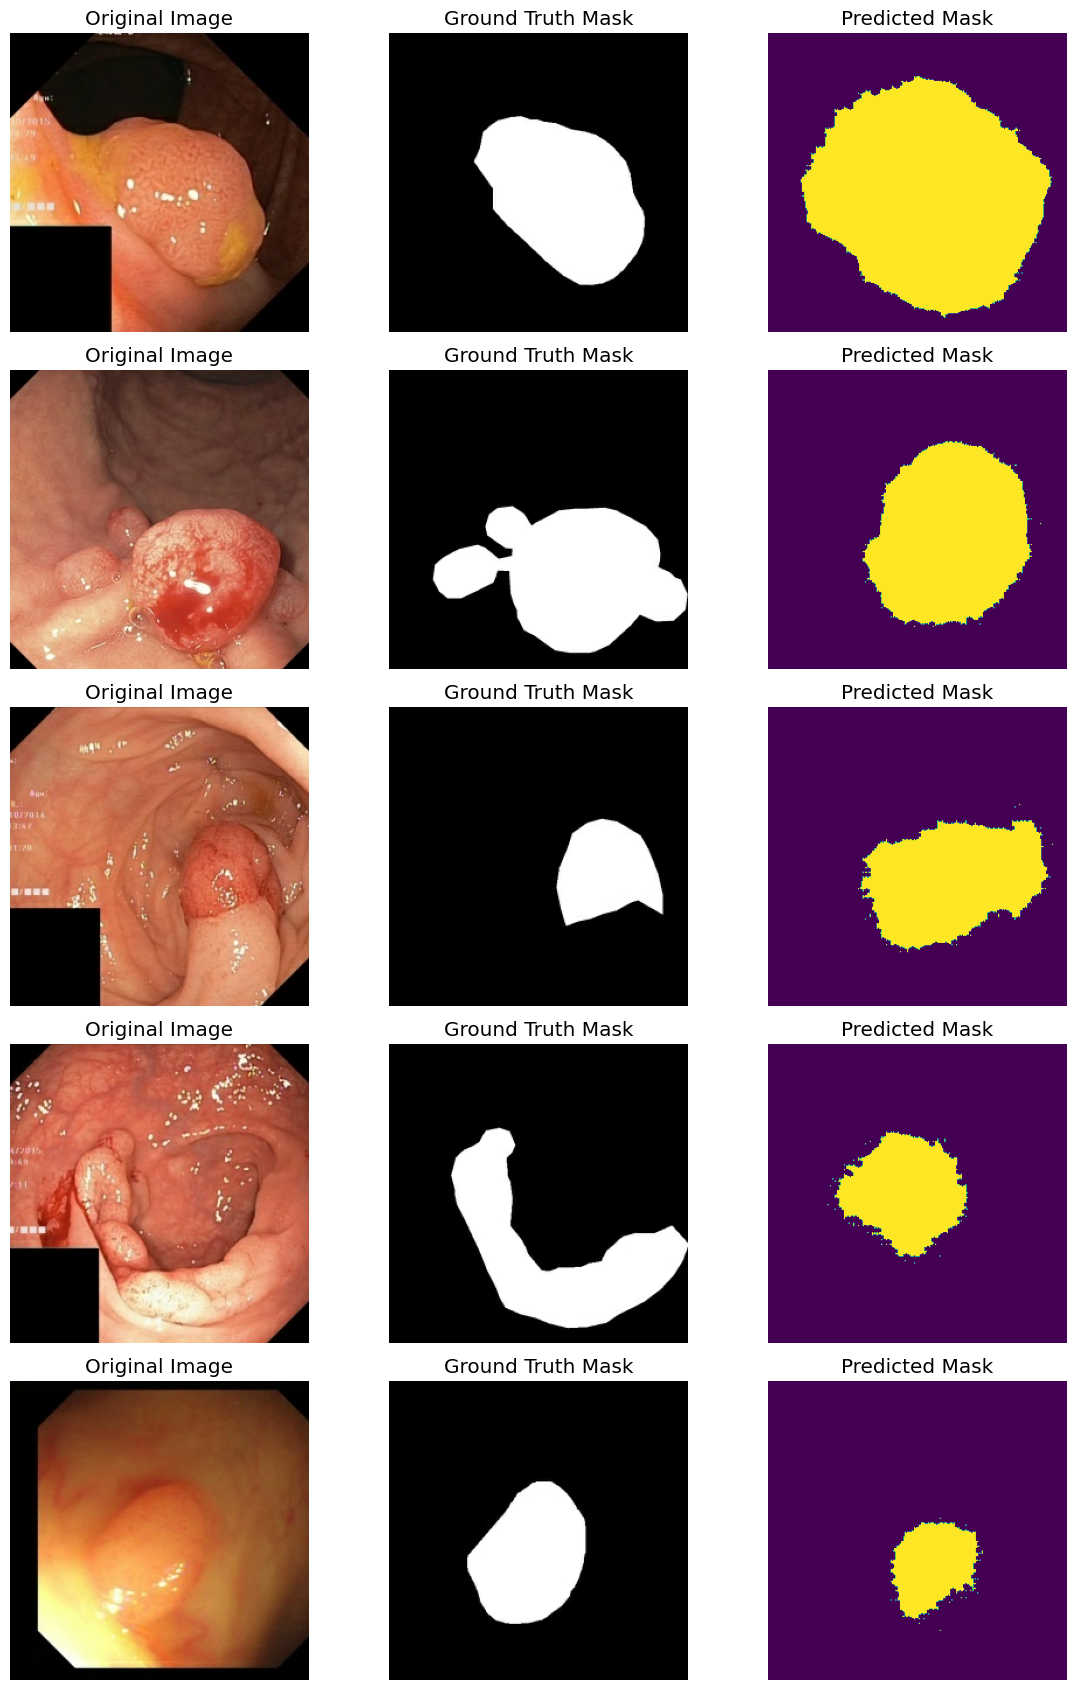

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Get the corresponding test image and mask (from only 1 batch)
test_batch = next(iter(test_dataset))
test_images, test_masks = test_batch

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_images)), 5)

# Generate predictions for the test images
predictions = model.predict(test_images, verbose=0)
reconstructed_images, segmentations = predictions

# Apply post-processing to the segmentation masks
segmentations_processed = np.array([post_process(seg) for seg in segmentations])

# Threshold the prediction to obtain the binary mask
binary_predictions = (segmentations_processed > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_images[random_index])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_masks[random_index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_predictions[random_index], cmap='viridis')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

The VAE segmentation model shows low capabilities in capturing the morphology of polyp regions, as indicated by its moderate mean IoU of 0.2443 and mean Dice coefficient of 0.3904. Inconsistencies in segmentation suggest refining spatial accuracy. Adjusting the prediction threshold to mitigate false positives while maintaining sensitivity to true positives is crucial, requiring careful consideration to strike a balance between accuracy and sensitivity.

<a name="conclusion"></a>
### Conclusion

The model exhibits strong classification accuracy, particularly in identifying background regions, with a precision of 92% and recall of 0.94%. However, its performance in detecting foreground (polyp) regions shows room for improvement, with a recall rate of only 44%. While achieving a moderate mean IoU of 0.2443 and mean Dice coefficient of 0.3904, indicating fair spatial agreement with ground truth masks, enhancing boundary delineation and overall segmentation accuracy remains a priority. Striking a balance between precision and recall is crucial for reliable polyp detection, necessitating careful threshold adjustments to minimize false positives without compromising sensitivity to true positives. Continuous refinement, informed by clinical expertise, is essential to optimize the model's effectiveness in polyp identification and segmentation tasks.